In this post, we look at AutoPyTorch, a framework for automated machine learning.

In [1]:
import os
import tempfile as tmp
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import sklearn.datasets
import sklearn.model_selection

os.environ['JOBLIB_TEMP_FOLDER'] = tmp.gettempdir()
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
from autoPyTorch.api.tabular_regression import TabularRegressionTask

In [3]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    random_state=1,
)

# Obtain training and validation data
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    X_train,
    y_train,
    random_state=1,
)


In [4]:
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
52,-0.052738,-0.044642,-0.009439,-0.005671,0.039710,0.044719,0.026550,-0.002592,-0.018118,-0.013504
121,0.063504,-0.044642,0.017506,0.021872,0.008063,0.021546,-0.036038,0.034309,0.019908,0.011349
170,0.023546,0.050680,-0.020218,-0.036656,-0.013953,-0.015092,0.059685,-0.039493,-0.096433,-0.017646
287,0.045341,-0.044642,-0.006206,-0.015999,0.125019,0.125198,0.019187,0.034309,0.032433,-0.005220
397,0.052606,-0.044642,-0.004050,-0.030918,-0.046975,-0.058307,-0.013948,-0.025840,0.036056,0.023775


In [5]:
y_train.head()

52      59.0
121    173.0
170     47.0
287    219.0
397    198.0
Name: target, dtype: float64

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_rf))

62.77500577100372

In [7]:
pred_df = pd.DataFrame({"rf": y_pred_rf, "true": y_test})
pred_df.head()

,rf,true
246,140.76,78.0
425,109.89,152.0
293,161.93,200.0
31,70.81,59.0
359,150.91,311.0


In [8]:
# Use validation dataset to find best hyperparameters for RF
rf = RandomForestRegressor(random_state=1)
hyperparameters = {"n_estimators": [10, 100, 1000], "max_depth": [1, 5, 10]}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(rf, hyperparameters, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(X_valid, y_valid)

grid_search.best_params_



{'max_depth': 5, 'n_estimators': 100}

In [9]:
# Train the RF model using the best hyperparameters on train + validation data

rf = RandomForestRegressor(**grid_search.best_params_, random_state=1)
# Combine train and validation data
X_train_overall = pd.concat([X_train, X_valid])
y_train_overall = pd.concat([y_train, y_valid])
rf.fit(X_train_overall, y_train_overall)
y_pred_rf = rf.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_rf))

61.69476644955032

In [10]:
api = TabularRegressionTask()

# Do an api search without any memory limit but use only MLPs

api.search(
    X_train=X_train_overall,
    y_train=y_train_overall,
    X_test=X_test.copy(),
    y_test=y_test.copy(),
    optimize_metric='r2',
    total_walltime_limit=80,
    func_eval_time_limit_secs=10,
    dataset_name="Diabetes",
    memory_limit=None,
    enable_traditional_pipeline=True,
    )

In [11]:
y_pred = api.predict(X_test)
score = api.score(y_pred, y_test)
print(score)
np.sqrt(mean_squared_error(y_test, y_pred))

{'r2': 0.3026643977627368}


60.33987680300709

In [12]:
# Print statistics from search
print(api.sprint_statistics())

autoPyTorch results:
	Dataset name: Diabetes
	Optimisation Metric: r2
	Best validation score: 0.4352600925944532
	Number of target algorithm runs: 13
	Number of successful target algorithm runs: 10
	Number of crashed target algorithm runs: 2
	Number of target algorithms that exceeded the time limit: 1
	Number of target algorithms that exceeded the memory limit: 0



In [13]:
api.get_models_with_weights()[0]

(0.62,
 MyTraditionalTabularRegressionPipeline(config='random_forest',
                                        dataset_properties={'categorical_columns': [],
                                                            'categories': [],
                                                            'input_shape': (10,),
                                                            'is_small_preprocess': True,
                                                            'issigned': True,
                                                            'issparse': False,
                                                            'numerical_columns': [0,
                                                                                  1,
                                                                                  2,
                                                                                  3,
                                                                                  4,
           

In [14]:
api.get_models_with_weights()[1]

(0.18,
 ________________________________________
 	TabularRegressionPipeline
 ________________________________________
 0-) imputer: 
 	SimpleImputer
 
 1-) variance_threshold: 
 	VarianceThreshold
 
 2-) coalescer: 
 	NoCoalescer
 
 3-) encoder: 
 	NoEncoder
 
 4-) scaler: 
 	StandardScaler
 
 5-) feature_preprocessor: 
 	NoFeaturePreprocessor
 
 6-) tabular_transformer: 
 	TabularColumnTransformer
 
 7-) preprocessing: 
 	EarlyPreprocessing
 
 8-) network_embedding: 
 	autoPyTorch.pipeline NoEmbedding
 
 9-) network_backbone: 
 	autoPyTorch.pipeline ShapedMLPBackbone
 
 10-) network_head: 
 	autoPyTorch.pipeline FullyConnectedHead
 
 11-) network: 
 	Sequential ({'random_state': RandomState(MT19937) at 0x19465E140, '_fit_requirements': [FitRequirement(name='network_head', supported_types=(<class 'torch.nn.modules.module.Module'>,), user_defined=False, dataset_property=False), FitRequirement(name='network_backbone', supported_types=(<class 'torch.nn.modules.module.Module'>,), user_def

In [15]:
api.get_models_with_weights()[2]

(0.16,
 MyTraditionalTabularRegressionPipeline(config='svm',
                                        dataset_properties={'categorical_columns': [],
                                                            'categories': [],
                                                            'input_shape': (10,),
                                                            'is_small_preprocess': True,
                                                            'issigned': True,
                                                            'issparse': False,
                                                            'numerical_columns': [0,
                                                                                  1,
                                                                                  2,
                                                                                  3,
                                                                                  4,
                     

What if we fit only NNs?

In [16]:
api2 = TabularRegressionTask(seed=2, ensemble_size=0)

api2.search(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test.copy(),
    y_test=y_test.copy(),
    optimize_metric='r2',
    total_walltime_limit=40,
    func_eval_time_limit_secs=10,
    dataset_name="Diabetes",
    memory_limit=None,
    enable_traditional_pipeline=False,
    )


[WARNING] [2023-02-27 18:29:06,260:Client-autoPyTorch.automl_common.common.utils.backend] Directory /var/folders/1x/wmgn24mn1bbd2vgbqlk98tbc0000gn/T/autoPyTorch_tmp_70d9fdb4-b69e-11ed-b5ea-3c7d0a00e5d9/.autoPyTorch/ensembles does not exist
[ERROR] [2023-02-27 18:29:06,261:Client-AutoPyTorch:Diabetes:2] No valid ensemble was created. Please check the logfile for errors. Default to the best individual estimator:[(2, 2, 5.555555555555555)]
NoneType: None


In [17]:
y_pred2 = api2.predict(X_test)
score2 = api2.score(y_pred2, y_test)
score2

{'r2': -0.37656772470491995}

In [18]:
np.sqrt(mean_squared_error(y_test, y_pred2))

84.77782906691597

Okay, it seems we are worse than the random forest. Let's see what happened.

In [19]:
api2.get_models_with_weights()[0]

(1.0,
 ________________________________________
 	TabularRegressionPipeline
 ________________________________________
 0-) imputer: 
 	SimpleImputer
 
 1-) variance_threshold: 
 	VarianceThreshold
 
 2-) coalescer: 
 	NoCoalescer
 
 3-) encoder: 
 	NoEncoder
 
 4-) scaler: 
 	StandardScaler
 
 5-) feature_preprocessor: 
 	NoFeaturePreprocessor
 
 6-) tabular_transformer: 
 	TabularColumnTransformer
 
 7-) preprocessing: 
 	EarlyPreprocessing
 
 8-) network_embedding: 
 	autoPyTorch.pipeline NoEmbedding
 
 9-) network_backbone: 
 	autoPyTorch.pipeline ShapedMLPBackbone
 
 10-) network_head: 
 	autoPyTorch.pipeline FullyConnectedHead
 
 11-) network: 
 	Sequential ({'random_state': RandomState(MT19937) at 0x194711A40, '_fit_requirements': [FitRequirement(name='network_head', supported_types=(<class 'torch.nn.modules.module.Module'>,), user_defined=False, dataset_property=False), FitRequirement(name='network_backbone', supported_types=(<class 'torch.nn.modules.module.Module'>,), user_defi

In [62]:
import torch
X_train_torch = torch.from_numpy(X_train.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
X_val_torch = torch.from_numpy(X_valid.values).float()
y_val_torch = torch.from_numpy(y_valid.values).float()
X_test_torch = torch.from_numpy(X_test.values).float()
y_test_torch = torch.from_numpy(y_test.values).float()

In [63]:
# Build a simple MLP in PyTorch, train on training data and optimize on validation data


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, l1 = 64, l2 = 64, l3 = 64, l2_reg = 0.0):
        super(Net, self).__init__()
        self.l2_reg = l2_reg
        self.fc1 = nn.Linear(10, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, l3)
        self.fc4 = nn.Linear(l3, 1)

    def forward(self, x):
        # Add a residual connection
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)



train_losses = []
val_losses = []
test_losses = []


for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
    optimizer.zero_grad()
    outputs = net(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    # Add L2 regularization
    for param in net.parameters():
        loss += net.l2_reg * torch.norm(param)
    loss.backward()
    optimizer.step()

    train_losses.append(np.sqrt(loss.item()))
    val_losses.append(np.sqrt(criterion(net(X_val_torch), y_val_torch).item()))
    test_losses.append(np.sqrt(criterion(net(X_test_torch), y_test_torch).item()))
            
print('Finished Training')


Finished Training


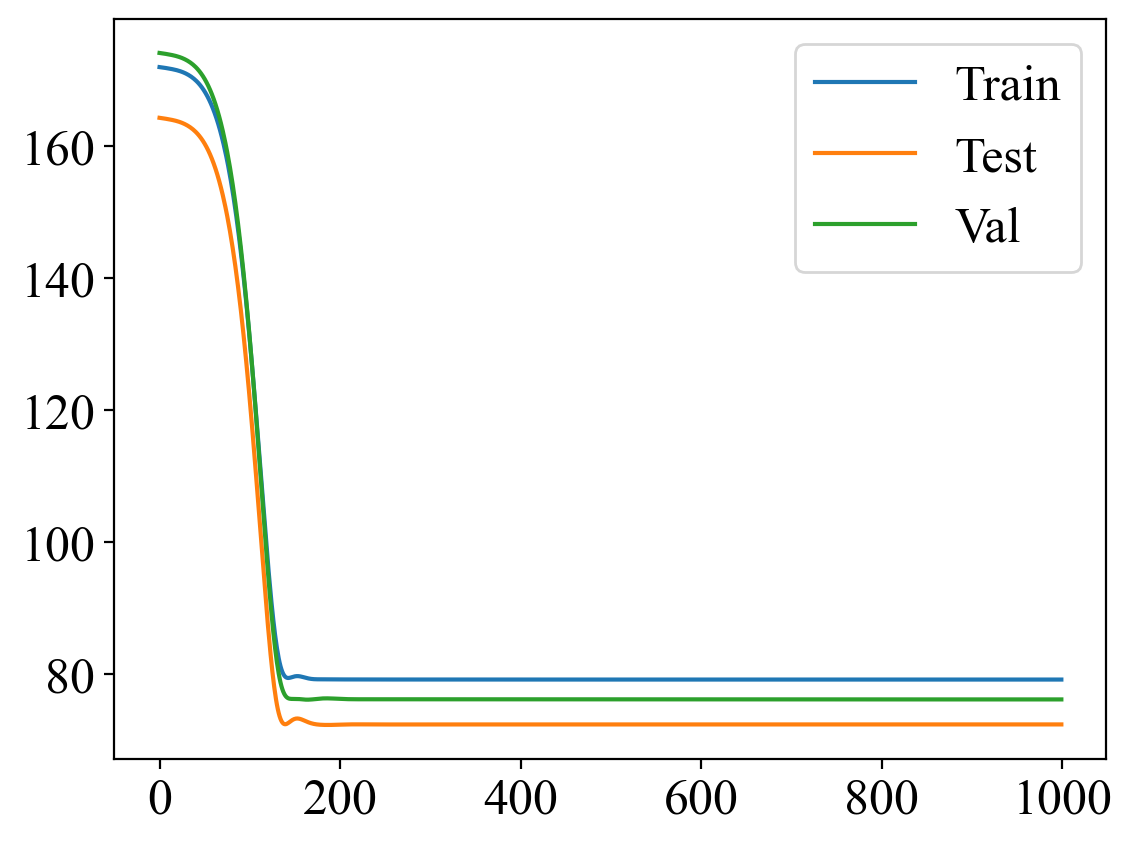

In [64]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.plot(val_losses, label="Val")
plt.legend()

In [65]:
with torch.no_grad():
    outputs = net(X_test_torch)
    loss = criterion(outputs, y_test_torch)
    print(f"Test loss: {np.sqrt(loss.item())}")
    outputs = net(X_train_torch)    
    loss = criterion(outputs, y_train_torch)
    print(f"Train loss: {np.sqrt(loss.item())}")
    print("")


Test loss: 72.43299031475574
Train loss: 79.2251754050993



In [70]:
# Fit the NN model using scaled y values
# Using sklearn's StandardScaler to scale the y values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_train_scaled = torch.from_numpy(y_train_scaled).float()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))
y_test_scaled = torch.from_numpy(y_test_scaled).float()
y_valid_scaled = scaler.transform(y_valid.values.reshape(-1, 1))
y_valid_scaled = torch.from_numpy(y_valid_scaled).float()

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

train_losses = []
val_losses = []
test_losses = []


for epoch in range(4000):  # loop over the dataset multiple times and store the train, test loss
    optimizer.zero_grad()
    outputs = net(X_train_torch)
    loss = criterion(outputs, y_train_scaled)
    # Add L2 regularization
    for param in net.parameters():
        loss += net.l2_reg * torch.norm(param)
    loss.backward()
    optimizer.step()

    train_losses.append(np.sqrt(loss.item()))

            
print('Finished Training')



Finished Training


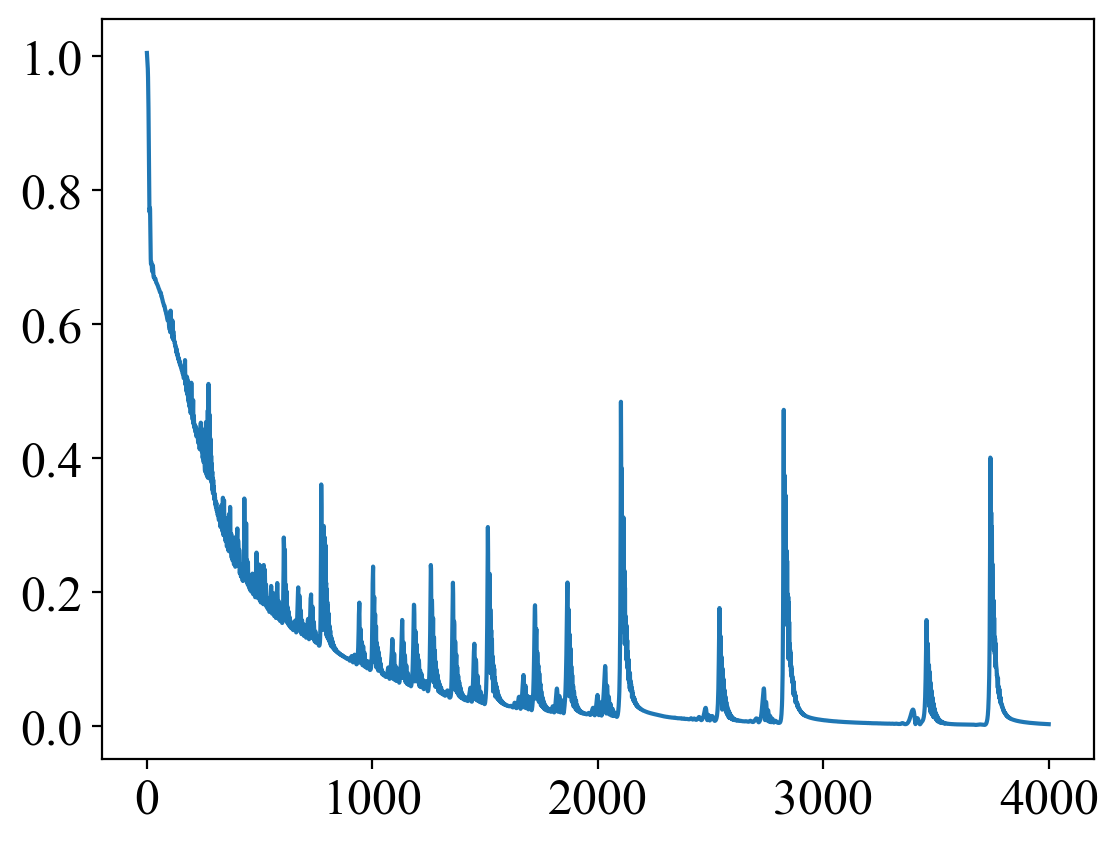

In [71]:
plt.plot(train_losses, label="Train")

In [72]:
# Predict the scaled y values and inverse transform them to get the original y values

with torch.no_grad():
    outputs = net(X_test_torch)

In [73]:
# Inverse transform the scaled y values to get the original y values

y_pred = scaler.inverse_transform(outputs.numpy())
y_pred = y_pred.reshape(-1)
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

Test RMSE: 82.79070717489064


<AxesSubplot: xlabel='y_test', ylabel='y_pred'>

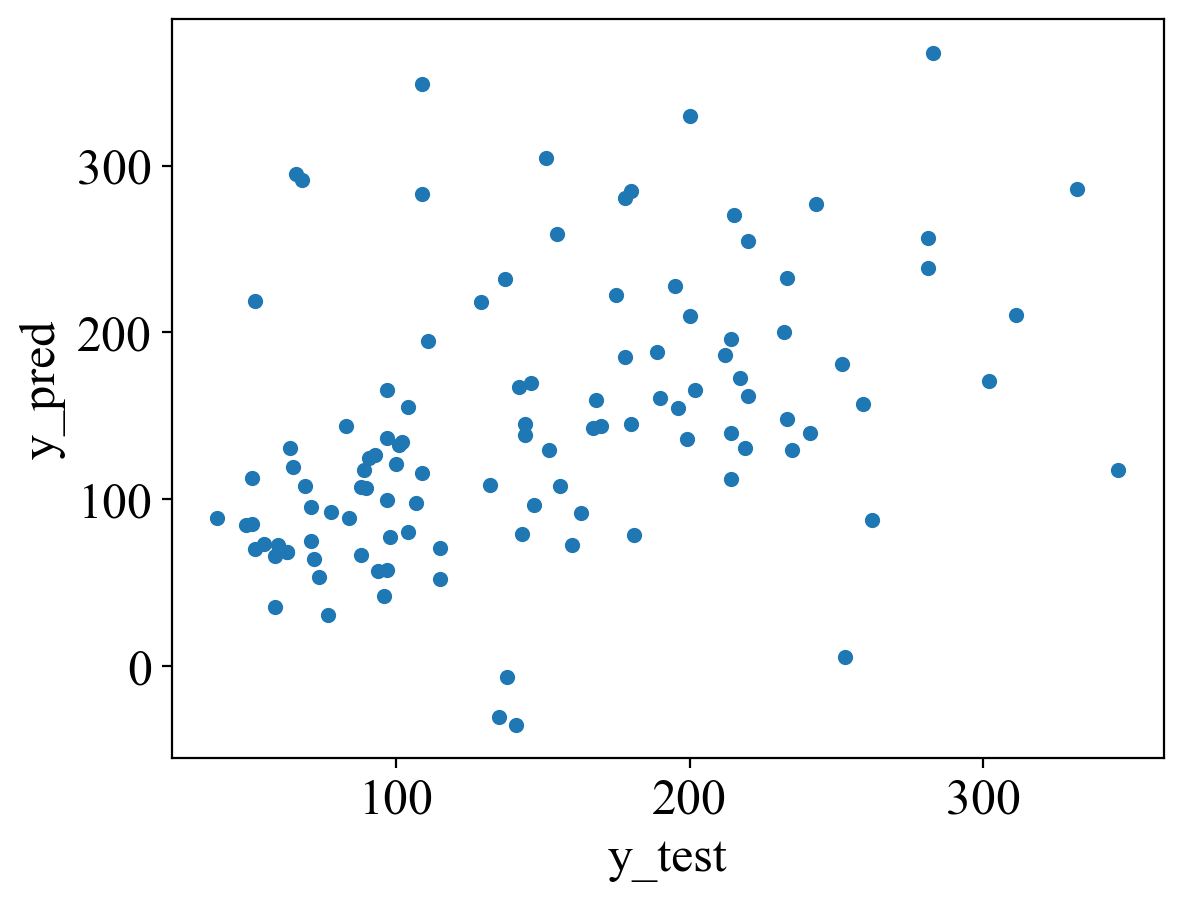

In [74]:
pd.DataFrame({"y_test": y_test, "y_pred": y_pred}).plot.scatter(x="y_test", y="y_pred")

In [75]:
# At this point it seems our model is worse than RF, Auto model containing Catboost etc. Let us optimize our NN
# I will use Ray Tune to optimize the hyperparameters

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

def train_mlp(config):
    net = Net(config["l1"], config["l2"], config["l3"], config["l2_reg"])
    
    criterion = nn.MSELoss()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
        optimizer.zero_grad()
        outputs = net(X_train_torch)
        loss = criterion(outputs, y_train_scaled)
        # Add l2 regularization to loss
        l2_reg = torch.tensor(0.)
        for param in net.parameters():
            l2_reg += torch.norm(param)
        loss += config["l2_reg"] * l2_reg
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        outputs = net(X_val_torch)
        # Inverse transform the scaled y values to get the original y values
        y_pred = scaler.inverse_transform(outputs.numpy())
        loss = np.sqrt(mean_squared_error(y_valid, y_pred))
        return {"loss": loss, "status": "ok"}


In [76]:
ray.shutdown()

ray.init()
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=100,
    grace_period=1,
    reduction_factor=2)

reporter = CLIReporter(
    parameter_columns=["l1", "l2", "l3", "lr", "l2_reg"],
    metric_columns=["loss", "training_iteration"])

analysis = tune.run(
    train_mlp,
    resources_per_trial={"cpu": 1},
    config={
        "l1": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l2": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l3": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l2_reg": tune.loguniform(1e-4, 1.0),
        "lr": tune.loguniform(1e-4, 1.0),
    },
    num_samples=50,
    scheduler=scheduler,
    progress_reporter=reporter)



Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,status,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mlp_c8d42_00000,2023-02-28_10-08-51,True,,684a45c7048544b384d756bd20117055,Nipuns-iMac-8.local,1,76.2275,127.0.0.1,99588,ok,2.44738,2.44738,2.44738,1677559131,0,,1,c8d42_00000,0.00341606
train_mlp_c8d42_00001,2023-02-28_10-08-59,True,,23a98dd3be3d4ad2abbc0a44970bd41b,Nipuns-iMac-8.local,1,76.2183,127.0.0.1,99594,ok,4.5987,4.5987,4.5987,1677559139,0,,1,c8d42_00001,0.00891805
train_mlp_c8d42_00002,2023-02-28_10-08-58,True,,f1614c13b37a4966adb785c911a54c11,Nipuns-iMac-8.local,1,76.2261,127.0.0.1,99595,ok,2.89705,2.89705,2.89705,1677559138,0,,1,c8d42_00002,0.0356119
train_mlp_c8d42_00003,2023-02-28_10-08-57,True,,e9475ee5dd1f4d1289ef144d1a7879ad,Nipuns-iMac-8.local,1,51.6545,127.0.0.1,99596,ok,2.83387,2.83387,2.83387,1677559137,0,,1,c8d42_00003,0.00670218
train_mlp_c8d42_00004,2023-02-28_10-08-57,True,,97bdec82d1ec44069bc84210c4a6a18e,Nipuns-iMac-8.local,1,65.3017,127.0.0.1,99597,ok,2.6755,2.6755,2.6755,1677559137,0,,1,c8d42_00004,0.00920701
train_mlp_c8d42_00005,2023-02-28_10-08-59,True,,3db458192e6944118049623bfe3128a4,Nipuns-iMac-8.local,1,76.1747,127.0.0.1,99598,ok,4.36245,4.36245,4.36245,1677559139,0,,1,c8d42_00005,0.00544381
train_mlp_c8d42_00006,2023-02-28_10-08-59,True,,6b794ba131304c9e841b2d671a1a4693,Nipuns-iMac-8.local,1,76.2181,127.0.0.1,99601,ok,4.51009,4.51009,4.51009,1677559139,0,,1,c8d42_00006,0.00939798
train_mlp_c8d42_00007,2023-02-28_10-09-06,True,,38d637c01fcb43d3be8db783cb837ea2,Nipuns-iMac-8.local,1,76.7874,127.0.0.1,99602,ok,11.1744,11.1744,11.1744,1677559146,0,,1,c8d42_00007,0.012325
train_mlp_c8d42_00008,2023-02-28_10-09-00,True,,a15c3445ce1e4ffeba2eabf9098820f2,Nipuns-iMac-8.local,1,76.1934,127.0.0.1,99604,ok,4.98043,4.98043,4.98043,1677559140,0,,1,c8d42_00008,0.010926
train_mlp_c8d42_00009,2023-02-28_10-09-00,True,,9de7e974434443f6a12e1dbc614a8582,Nipuns-iMac-8.local,1,68.2169,127.0.0.1,99612,ok,5.00434,5.00434,5.00434,1677559140,0,,1,c8d42_00009,0.00496888


2023-02-28 10:09:11,027	INFO tune.py:762 -- Total run time: 26.09 seconds (25.84 seconds for the tuning loop).


In [77]:
# Print the table for all the trials
df = analysis.results_df

# Sort the table by loss
df.sort_values(by="loss", inplace=True)

# Show only loss, config/l1, config/l2, config/l3, config/lr, training_iteration
df[["loss", "config/l1", "config/l2", "config/l3", "config/lr", "config/l2_reg"]]

,loss,config/l1,config/l2,config/l3,config/lr,config/l2_reg
trial_id,,,,,,
c8d42_00019,51.555930,256,256,128,0.000125,0.027615
c8d42_00015,51.580817,4,64,256,0.003980,0.015450
c8d42_00003,51.654479,2,64,4,0.000991,0.015054
c8d42_00037,51.872128,128,32,32,0.000114,0.005181
c8d42_00031,51.925027,128,64,32,0.000103,0.001919
c8d42_00045,51.933658,64,256,16,0.000139,0.000221
c8d42_00034,51.967532,2,128,128,0.000371,0.000860
c8d42_00011,52.207469,16,256,128,0.000134,0.001002
c8d42_00018,52.479806,2,16,4,0.002317,0.000166


In [78]:
# Print the best hyperparameters

analysis.get_best_config(metric="loss", mode="min")

{'l1': 256,
 'l2': 256,
 'l3': 128,
 'l2_reg': 0.027614886800457164,
 'lr': 0.00012453571993239395}

In [79]:
# Perform the final test on the test set

best_config = analysis.get_best_config(metric="loss", mode="min")

# Use the best hyperparameters to train the model
net = Net(best_config["l1"], best_config["l2"], best_config["l3"], best_config["l2_reg"])
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=best_config["lr"])
for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
    optimizer.zero_grad()
    outputs = net(X_train_torch)
    loss = criterion(outputs, y_train_scaled)
    # Add L2 regularization
    for param in net.parameters():
        loss += net.l2_reg * torch.norm(param)

    
    loss.backward()
    optimizer.step()

with torch.no_grad():
    outputs = net(X_test_torch)
    # Inverse transform the scaled y values to get the original y values
    y_pred = scaler.inverse_transform(outputs.numpy())
    loss = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Test RMSE: {loss}")
    print("")
    

Test RMSE: 54.06271747689579



In [80]:
pd.DataFrame({"y_test": y_test, "y_pred": y_pred.reshape(-1)})

,y_test,y_pred
246,78.0,107.765800
425,152.0,110.693916
293,200.0,175.535324
31,59.0,82.328522
359,311.0,176.440598
...,...,...
117,281.0,246.310699
139,281.0,245.451309
218,214.0,118.843346
93,96.0,77.727440


In [81]:
# Thus far it seems even with hyperparameter tuning we are unable to match the performance of ensemble models. 

# Get the top 5 configurations

df[['loss', 'config/l1', 'config/l2', 'config/l3', 'config/lr', 'config/l2_reg']].head(5)


,loss,config/l1,config/l2,config/l3,config/lr,config/l2_reg
trial_id,,,,,,
c8d42_00019,51.555930,256,256,128,0.000125,0.027615
c8d42_00015,51.580817,4,64,256,0.003980,0.015450
c8d42_00003,51.654479,2,64,4,0.000991,0.015054
c8d42_00037,51.872128,128,32,32,0.000114,0.005181
c8d42_00031,51.925027,128,64,32,0.000103,0.001919


In [82]:
config_list_of_dicts = df[['config/l1', 'config/l2', 'config/l3', 'config/lr', 'config/l2_reg']].head(5).to_dict('records')

# Train an ensemble of 5 models using the top 5 configurations

ensemble = []
for config in config_list_of_dicts:
    net = Net(config["config/l1"], config["config/l2"], config["config/l3"], config["config/l2_reg"])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["config/lr"])
    for epoch in range(2000):  # loop over the dataset multiple times and store the train, test loss
        optimizer.zero_grad()
        outputs = net(X_train_torch)
        loss = criterion(outputs, y_train_scaled)
        # Add L2 regularization
        for param in net.parameters():
            loss += net.l2_reg * torch.norm(param)
        loss.backward()
        optimizer.step()
    ensemble.append(net)


In [83]:
# Get the predictions from the ensemble

ensemble_preds = []
for net in ensemble:
    with torch.no_grad():
        outputs = net(X_test_torch)
        # Scale the predictions back to the original scale
        outputs = scaler.inverse_transform(outputs.numpy())
        ensemble_preds.append(outputs)
    
ensemble_preds = np.array(ensemble_preds)

# Get the mean of the predictions

ensemble_preds_mean = ensemble_preds.mean(axis=0)

# Get the RMSE of the ensemble

criterion = nn.MSELoss()
loss = criterion(torch.tensor(ensemble_preds_mean), y_test_torch)
print(f"Test loss: {np.sqrt(loss.item())}")


Test loss: 83.04458927945727


## Inputs to Meta Learning model


### Data inputs

1. Input vector: X is of shape N, D where N is the number of samples and D is the number of features
2. Output vector: y is of shape N, 1

### Encoder inputs

3. Context vector: Containing C vectors of concatenated (X, y) pairs from the training set. Thus, shape of context vector is (C, D + 1)

### Encoder internals
-----------------
4. Encoding: Encoder is a neural network that takes in the context vector and outputs a vector of shape (C, E) where E is the encoding size

### Encoder outputs
---------------
5. Encoder summary: A vector of shape (E, ) that is the mean of the encoding

### Decoder inputs
--------------
6. Query vector: Containing Q vectors of X from test set. Thus, shape of query vector is (Q, D)
7. It also takes the encoder summary as input of size (E, ). But, we make Q copies of the encoder summary and concatenate it with the query vector to get a vector of shape (Q, E + D)

### Decoder outputs
-----------------
8. Decoding: Decoder is a neural network that takes in the query vector and encoder summary and outputs a vector of shape (Q, 1)


In [84]:
D = X_train_torch.shape[1]


In [85]:
# Building the encoder 
# Takes as input the number of features, the number of nodes in 3 hidden layers, and the L2 regularization parameter

class Encoder(nn.Module):
    def __init__(self, n_features = D+1, l1_size=32, l2_size=32, E = 32, l2_reg=0.0):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(n_features, l1_size)
        self.l2 = nn.Linear(l1_size, l2_size)
        self.l3 = nn.Linear(l2_size, E)
        self.l2_reg = l2_reg
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        return x


In [86]:
# Create C context vectors and pass them through the encoder

C = 5
Q = 2
encoder = Encoder(E=32)

# Create the context vectors input
C_idx = np.random.choice(X_train_torch.shape[0], C, replace=False)
C_idx = torch.tensor(C_idx)

# Get the Q query vectors
all_idx = np.arange(X_train_torch.shape[0])
Q_idx = np.random.choice(np.setdiff1d(all_idx, C_idx), Q, replace=False)
Q_idx = torch.tensor(Q_idx)

C_idx, Q_idx

(tensor([108,  26,  25, 210, 151]), tensor([156, 230]))

In [87]:
X_train_torch[C_idx], y_train_scaled[C_idx], y_train_torch[C_idx]

(tensor([[-0.0019, -0.0446,  0.0542, -0.0665,  0.0727,  0.0566, -0.0434,  0.0849,
           0.0845,  0.0486],
         [ 0.0817,  0.0507,  0.0013,  0.0356,  0.1264,  0.0911,  0.0192,  0.0343,
           0.0845, -0.0301],
         [ 0.0126, -0.0446,  0.0067, -0.0562, -0.0759, -0.0664, -0.0213, -0.0376,
          -0.0181, -0.0922],
         [ 0.0272, -0.0446,  0.0067,  0.0356,  0.0796,  0.0707,  0.0155,  0.0343,
           0.0407,  0.0113],
         [-0.0709,  0.0507, -0.0752, -0.0401, -0.0511, -0.0151, -0.0397, -0.0026,
          -0.0964, -0.0342]]),
 tensor([[ 0.4966],
         [ 0.5471],
         [ 0.3704],
         [-1.0812],
         [-1.2327]]),
 tensor([192., 196., 182.,  67.,  55.]))

In [88]:
context_input = torch.cat((X_train_torch[C_idx], y_train_scaled[C_idx].reshape(-1, 1)), axis=1)
pd.DataFrame(context_input)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.001882,-0.044642,0.054152,-0.066495,0.072732,0.056619,-0.043401,0.084863,0.084495,0.048628,0.496595
1,0.081666,0.050680,0.001339,0.035644,0.126395,0.091065,0.019187,0.034309,0.084495,-0.030072,0.547084
2,0.012648,-0.044642,0.006728,-0.056166,-0.075870,-0.066449,-0.021311,-0.037648,-0.018118,-0.092204,0.370372
3,0.027178,-0.044642,0.006728,0.035644,0.079612,0.070710,0.015505,0.034309,0.040672,0.011349,-1.081190
4,-0.070900,0.050680,-0.075186,-0.040099,-0.051103,-0.015092,-0.039719,-0.002592,-0.096433,-0.034215,-1.232658


In [89]:
encoder(context_input).shape

torch.Size([5, 32])

In [90]:
encoder(context_input).mean(axis=0).shape


torch.Size([32])

In [91]:
# Now we will build the decoder

class Decoder(nn.Module):
    def __init__(self, E=32, l1_size=32, l2_size=32, l2_reg=0.0):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(E, l1_size)
        self.l2 = nn.Linear(l1_size, l2_size)
        self.l3 = nn.Linear(l2_size, 1)
        self.l2_reg = l2_reg
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        return x

In [92]:
# Pass Q query vectors and the context vectors through the decoder

decoder = Decoder(E =32 + D)
mean_context = encoder(context_input).mean(axis=0)
# Repeat the mean context vector Q times
mean_context = mean_context.repeat(Q, 1)
mean_context.shape

torch.Size([2, 32])

In [93]:
query = X_train_torch[Q_idx]
query.shape

torch.Size([2, 10])

In [94]:
input_decoder = torch.cat((query, mean_context), axis=1)
input_decoder.shape

torch.Size([2, 42])

In [95]:
decoder(input_decoder).shape

torch.Size([2, 1])

In [96]:
# Building a meta learning class

class Meta(nn.Module):
    def __init__(self, D = X_train_torch.shape[1], E = 32,  C = 10, Q = 2, l1_size=32, l2_size=32, l2_reg=0.0):
        super(Meta, self).__init__()
        self.encoder = Encoder(D + 1, l1_size, l2_size, E, l2_reg)
        self.decoder = Decoder(E + D, l1_size, l2_size, l2_reg)
        self.D = D
        self.E = E
        self.C = C
        self.Q = Q
        self.l2_reg = l2_reg

    def forward(self, context_input, query):
        mean_context = self.encoder(context_input).mean(axis=0)
        # Repeat the mean context vector Q times
        mean_context = mean_context.repeat(self.Q, 1)
        input_decoder = torch.cat((query, mean_context), axis=1)
        return self.decoder(input_decoder)


In [97]:
m = Meta()
m(context_input, query)

tensor([[0.],
        [0.]], grad_fn=<ReluBackward0>)

In [98]:
# Create a function to get the context and query vectors

def get_context_query(X, y, C, Q):
    C_idx = np.random.choice(X.shape[0], C, replace=False)
    C_idx = torch.tensor(C_idx)
    all_idx = np.arange(X.shape[0])
    Q_idx = np.random.choice(np.setdiff1d(all_idx, C_idx), Q, replace=False)
    Q_idx = torch.tensor(Q_idx)
    context_input = torch.cat((X[C_idx], y[C_idx].reshape(-1, 1)), axis=1)
    query = X[Q_idx]
    return context_input, query, y[Q_idx]

In [99]:
get_context_query(X_train_torch, y_train_torch, 10, 2)

(tensor([[-6.0003e-02, -4.4642e-02,  1.3387e-03, -2.9771e-02, -7.0728e-03,
          -2.1669e-02,  1.1824e-02, -2.5923e-03,  3.1815e-02, -5.4925e-02,
           2.5800e+02],
         [ 3.0811e-02, -4.4642e-02, -5.0396e-02, -2.2277e-03, -4.4223e-02,
          -8.9935e-02,  1.1859e-01, -7.6395e-02, -1.8118e-02,  3.0644e-03,
           8.7000e+01],
         [ 6.7136e-02, -4.4642e-02,  3.4944e-03,  3.5644e-02,  4.9341e-02,
           3.1254e-02,  7.0730e-02, -3.9493e-02, -6.0925e-04,  1.9633e-02,
           7.3000e+01],
         [ 1.2648e-02, -4.4642e-02,  6.7278e-03, -5.6166e-02, -7.5870e-02,
          -6.6449e-02, -2.1311e-02, -3.7648e-02, -1.8118e-02, -9.2204e-02,
           1.8200e+02],
         [-6.3635e-02,  5.0680e-02, -7.9497e-02, -5.6706e-03, -7.1743e-02,
          -6.6449e-02, -1.0266e-02, -3.9493e-02, -1.8118e-02, -5.4925e-02,
           1.0100e+02],
         [-1.8820e-03, -4.4642e-02, -6.6563e-02,  1.2151e-03, -2.9449e-03,
           3.0702e-03,  1.1824e-02, -2.5923e-03, -2.028

In [100]:
# Training loop

train_loss = []
val_losses = []
test_losses = []
for i in range(2000):
    context_input, query, y_query = get_context_query(X_train_torch, y_train_scaled, 10, 2)
    y_pred = m(context_input, query)
    loss = criterion(y_pred, y_query)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if i % 100 == 0:
        print(f"Epoch {i} - Train loss: {loss.item()}")



Epoch 0 - Train loss: 0.2789093554019928
Epoch 100 - Train loss: 1.1788500547409058
Epoch 200 - Train loss: 0.6084457039833069
Epoch 300 - Train loss: 0.6604040265083313
Epoch 400 - Train loss: 0.6397659778594971
Epoch 500 - Train loss: 0.18253237009048462
Epoch 600 - Train loss: 0.4401477575302124
Epoch 700 - Train loss: 0.19387057423591614
Epoch 800 - Train loss: 1.3166064023971558
Epoch 900 - Train loss: 0.4808962345123291
Epoch 1000 - Train loss: 0.2843365967273712
Epoch 1100 - Train loss: 0.35177987813949585
Epoch 1200 - Train loss: 1.1539983749389648
Epoch 1300 - Train loss: 2.0983378887176514
Epoch 1400 - Train loss: 3.325526237487793
Epoch 1500 - Train loss: 0.38105207681655884
Epoch 1600 - Train loss: 0.16427072882652283
Epoch 1700 - Train loss: 1.9909170866012573
Epoch 1800 - Train loss: 0.03792643919587135
Epoch 1900 - Train loss: 2.758319854736328


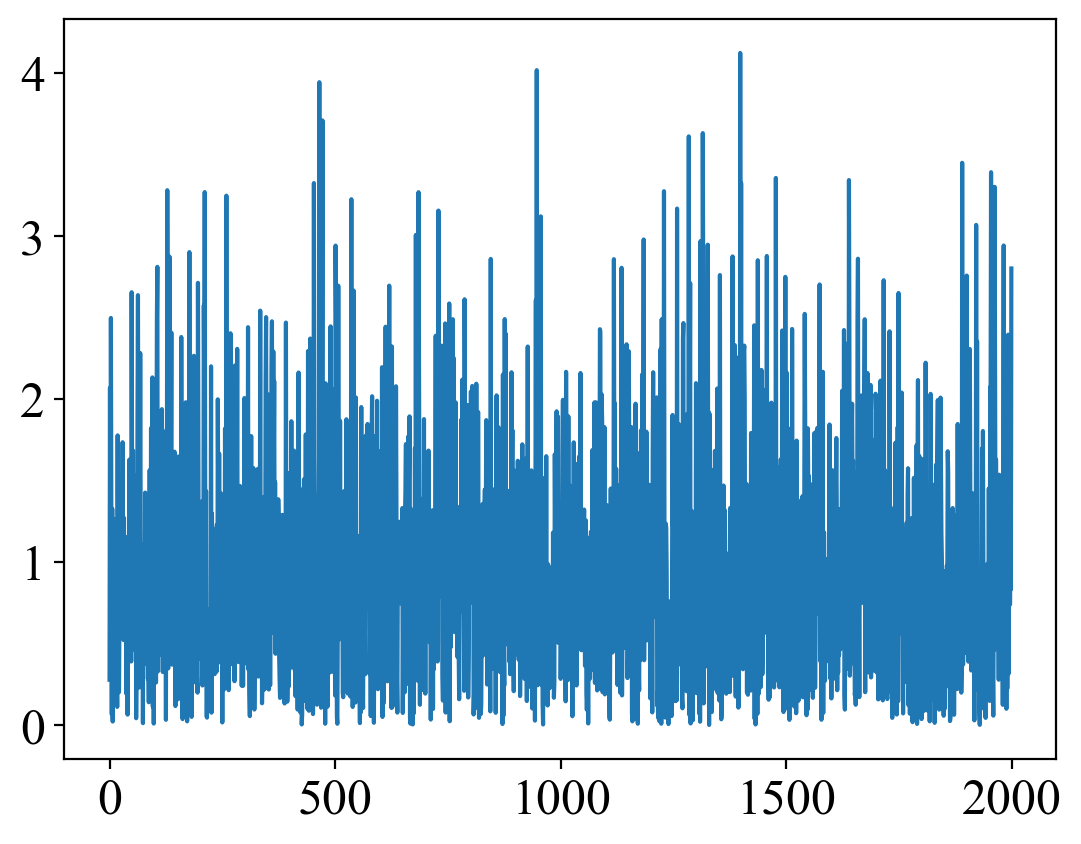

In [101]:
plt.plot(train_loss)

In [102]:
context_input, _, _ = get_context_query(X_train_torch, y_train_torch, 10, query.shape[0])
context_input.shape

torch.Size([10, 11])

In [103]:
X_test_torch.shape

torch.Size([111, 10])

In [104]:
query.shape

torch.Size([2, 10])

In [105]:
context_input.shape

torch.Size([10, 11])

In [106]:
# Use whole of the test set as the query set
query = X_test_torch
y_query = y_test_torch

# get context from the training set
context_input, _, _ = get_context_query(X_train_torch, y_train_scaled, 10, query.shape[0])


m = Meta(C=10, Q=query.shape[0])

y_pred = m(context_input, query)

# Use inverse transform to get the original values

y_pred = scaler.inverse_transform(y_pred.detach().numpy())
print(f"Test loss: {np.sqrt(mean_squared_error(y_query, y_pred))}")


Test loss: 75.22261810302734


In [107]:
pd.DataFrame({"y_pred": y_pred.reshape(-1), "y_query": y_query})

,y_pred,y_query
0,169.061569,78.0
1,168.179596,152.0
2,168.527161,200.0
3,168.452423,59.0
4,168.826492,311.0
...,...,...
106,169.100494,281.0
107,168.457611,281.0
108,169.019516,214.0
109,168.639725,96.0
